# 3.1 卷积神经网络和AlexNet（上）

恭喜你已经完成了前两章的学习，在第三章，我们将介绍在深度学习领域那些最具有影响力的论文，这些论文是这个领域最重要的奠基之作，许多思想对后续的研究产生了深远的影响，在本节我们将介绍这一波深度学习热潮的起点，诞生自2012年ImageNet这个比赛上的模型，AlexNet。可以说没有AlexNet的成功，就不会吸引如此的的科学家和工程师在深度学习领域的研究，也就不会有现如今的人工智能狂潮。

在本节我们会介绍一种经典的模型，卷积神经网络，这种模型过去被普遍用来处理图像相关的任务，像图像识别，人脸识别，目标检测，像素分割。尽管这几年transformer架构在图像领域也取得了瞩目的进展，但我们从理解图像，编程练习，以及小规模的神经网络模型构建上，学习卷积神经网络也同样是有意义的。

![LeNet网络结构](imgs/nn_lenet.png)

我们首先把上一章的代码整合到mytorch文件夹中，看吧，我们的代码和语法结构已经和pytorch很像了，为每个能做到这一步的同学点个赞，你已经比这个世界上绝大多数干人工智能这一行的人强很多了，如果你能学完所有的课程，你将深刻理解深度学习领域的每一个算法细节，你能很容易的get到一篇最新论文的知识和技术点甚至自己立刻实现这一新技术，最后你甚至能看出一些论文可能存在的学术欺诈和一些算法背后的改进空间，你不光会成为一个知道自己知道的人，你还会成为一个不知道自己的知道的人。

In [2]:
import sys
sys.path.append('.')

In [3]:
import numpy as np
from mytorch import Tensor, nn

In [4]:
class TestNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(2, 4)
        self.l2 = nn.Linear(4, 5)

    def forward(self, x):
        x = self.l1(x)
        x = x.relu()
        x = self.l2(x)
        return x    
    
test = TestNet()
print(test)
test(Tensor.from_numpy(np.random.rand(1,2)))

TestNet(
  (l1): Linear(in_features=2, out_features=4, bias=True)
  (l2): Linear(in_features=4, out_features=5, bias=True)
)


Tensor(data=[[2.6861825  0.92213412 2.29452671 3.57819071 2.38783342]], grad=[[0. 0. 0. 0. 0.]], trainable=True)

## 卷积层
卷积层可以产生一组平行的特征图（feature map），它通过在输入图像上滑动不同的卷积核并执行一定的运算而组成。此外，在每一个滑动的位置上，卷积核与输入图像之间会执行一个元素对应乘积并求和的运算以将感受野内的信息投影到特征图中的一个元素。这一滑动的过程可称为步幅 Z_s，步幅 Z_s 是控制输出特征图尺寸的一个因素。卷积核的尺寸要比输入图像小得多，且重叠或平行地作用于输入图像中，一张特征图中的所有元素都是通过一个卷积核计算得出的，也即一张特征图共享了相同的权重和偏置项。（摘自维基百科）

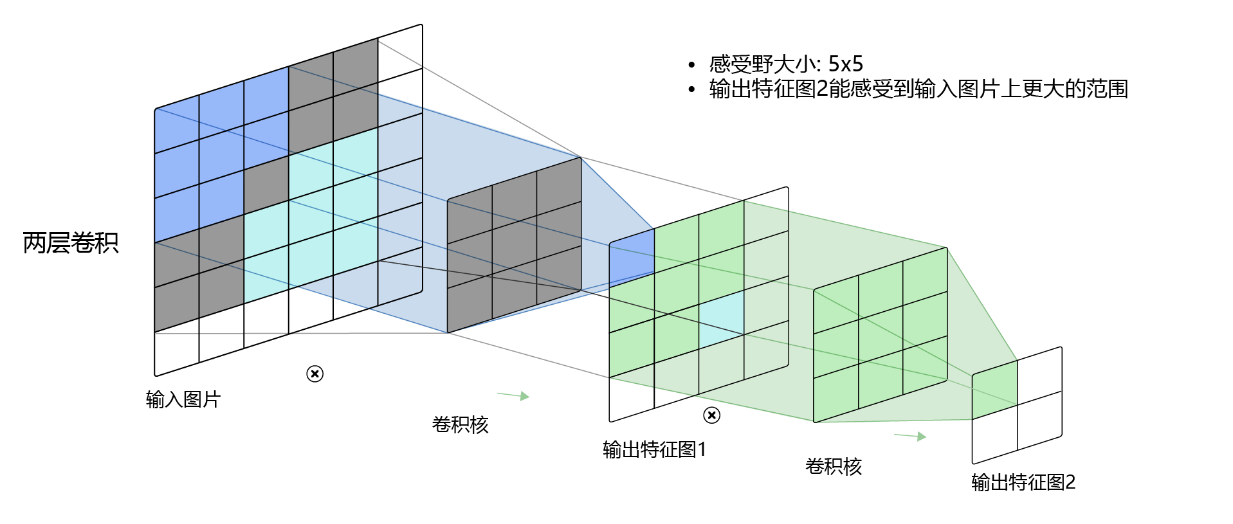

下面这张图片详细介绍了卷积计算的过程：<br>
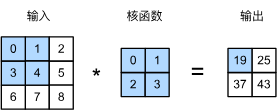

In [5]:
import numpy as np

class Conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding="SAME_PADDING"):
        """
        初始化2D卷积层。

        参数:
        in_channels (int): 输入通道数。
        out_channels (int): 输出通道数。
        kernel_size (int or tuple): 卷积核的大小。可以是一个整数或一个二元组。
        stride (int or tuple): 卷积的步长。可以是一个整数或一个二元组。默认为1。
        padding (int or tuple): 输入数据的填充量。可以是一个整数或一个二元组。默认为0。
        """
        assert(padding, "SAME_PADDING")
        assert(stride, 1)
        assert(kernel_size, 3)
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        # 初始化权重和偏置
        self.weight = Tensor(np.random.randn(out_channels, in_channels, *self.kernel_size))
        self.bias = Tensor(np.random.randn(out_channels))

    def forward(self, x):
        pass

    def __repr__(self):
        return f"Conv2d(in_channels={self.in_channels}, out_channels={self.out_channels}, kernel_size=3, stride=1, padding=SAME_PADDING)"


<>:15: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:15: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/var/folders/k6/4t4w70zn0gx11g71k5f4zp000000gn/T/ipykernel_2228/2625779249.py:15: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(padding, "SAME_PADDING")


让我们详细解释下这几个参数的含义<br>
输入通道数：这个参数表示输入数据的通道数。例如，在处理彩色图像时，通常有三个通道，分别对应红色、绿色和蓝色，所以in_channels会是3。<br>
输出通道数：这个参数表示卷积层将产生的输出数据的通道数。这不仅取决于输入数据，还取决于模型的架构和你想要学习的特征数量。<br>
卷积核大小：卷积核是在输入数据上滑动以进行卷积操作的小窗口。kernel_size定义了这个窗口的大小。它可以是一个整数（表示一个正方形的卷积核），也可以是一个二元组（表示矩形的卷积核）。<br>
步长：步长定义了卷积核在输入数据上滑动时的步幅大小。较大的步长会导致输出尺寸减小。它也可以是一个整数（在所有方向上相同的步长）或一个二元组（不同方向上不同的步长）。<br>
填充量：在进行卷积操作之前，有时会在输入数据的边界添加额外的“零”来调整输出的尺寸。填充可以是一个整数（在所有边界上相同的填充量）或一个二元组（不同边界上不同的填充量）。

In [ ]:
import numpy as np

class Conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding="SAME_PADDING"):
        """
        初始化2D卷积层。

        参数:
        in_channels (int): 输入通道数。
        out_channels (int): 输出通道数。
        kernel_size (int or tuple): 卷积核的大小。可以是一个整数或一个二元组。
        stride (int or tuple): 卷积的步长。可以是一个整数或一个二元组。默认为1。
        padding (int or tuple): 输入数据的填充量。可以是一个整数或一个二元组。默认为0。
        """
        assert(padding, "SAME_PADDING")
        assert(stride, 1)
        assert(kernel_size, 3)
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        # 初始化权重和偏置
        self.weight = Tensor(np.random.randn(out_channels, in_channels, 3))
        self.bias = Tensor(np.random.randn(out_channels))

    def forward(self, x):
        assert isinstance(x, np.ndarray)
        def pad_with(vector, pad_width, iaxis, kwargs):
            pad_value = kwargs.get('padder', 10)
            vector[:pad_width[0]] = pad_value
            vector[-pad_width[1]:] = pad_value
        height, width = x.shape[1], x.shape[2]
        x_padded = np.pad(x, 1, pad_with, padder=0)

        out = np.zeros((self.out_channels, height, width))
        
        # 执行卷积
        for c in range(self.out_channels):  # 遍历输出通道
            for h in range(height):  # 遍历高度
                for w in range(width):  # 遍历宽度
                    x_slice = x_padded[:, h:h+3, w:w+3]
                    out[c, h, w] = np.sum(x_slice * self.weight[c, :, :, :]) + self.bias[c]
        
        return out

    def __repr__(self):
        return f"Conv2d(in_channels={self.in_channels}, out_channels={self.out_channels}, kernel_size=3, stride=1, padding=SAME_PADDING)"
